In [53]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [54]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [55]:
EPOCHS = 100
LR = 1e-3
BS = 32
SEED = 42

In [56]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED) # Seed 고정

# EDA


In [5]:
df = pd.read_csv('./creditcard.csv') #data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Data는 원래의 데이터를 PCA를 사용해 28차원으로 축소한 28개의 특성과 시간, 거래금액, Label이 존재하는 데이터

In [6]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Data는 심각한 불균형을 이루고 있는 것을 확인 가능

In [7]:
df.drop(['Time','Amount'],axis=1,inplace=True)
print(df)

               V1         V2        V3        V4        V5        V6   
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388  \
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V20       V21   
0       0.239599  0.098698  0.363787  0.090794  ...  0.25141

이 주제에서는 원본 데이터에 차원축소가 진행된 28개의 특성인 V1~V28만 사용할 예정

In [8]:
df.shape 

(284807, 29)

In [9]:
df.isnull().sum() #결측치 존재하지 않음

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
V11      0
V12      0
V13      0
V14      0
V15      0
V16      0
V17      0
V18      0
V19      0
V20      0
V21      0
V22      0
V23      0
V24      0
V25      0
V26      0
V27      0
V28      0
Class    0
dtype: int64

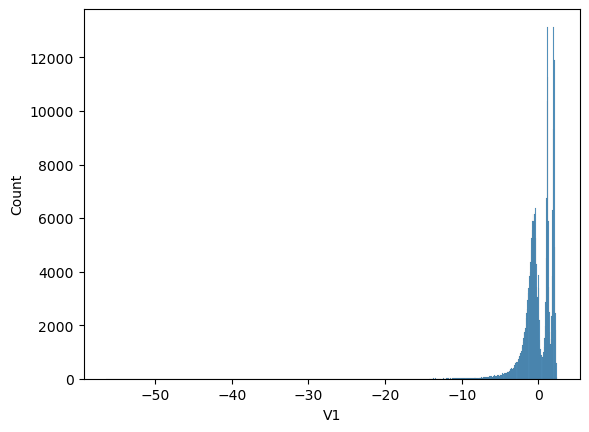

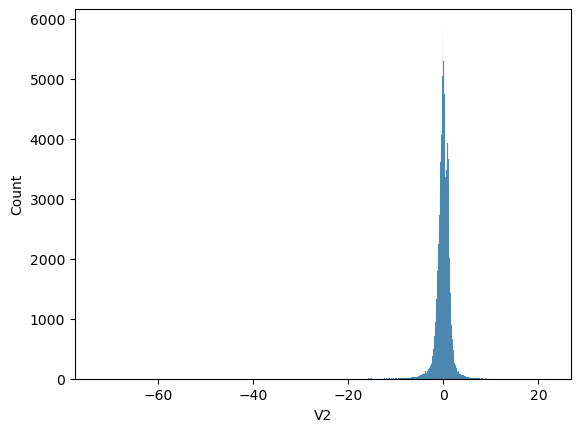

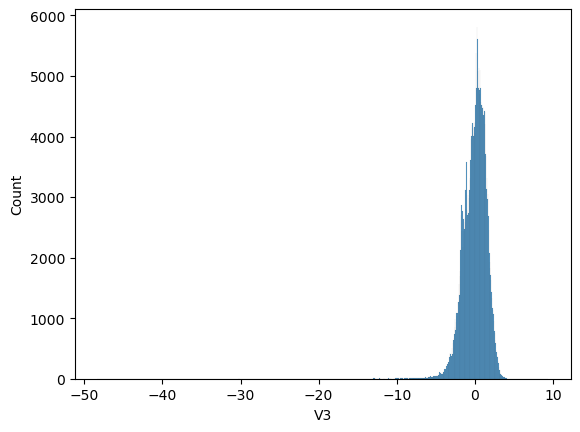

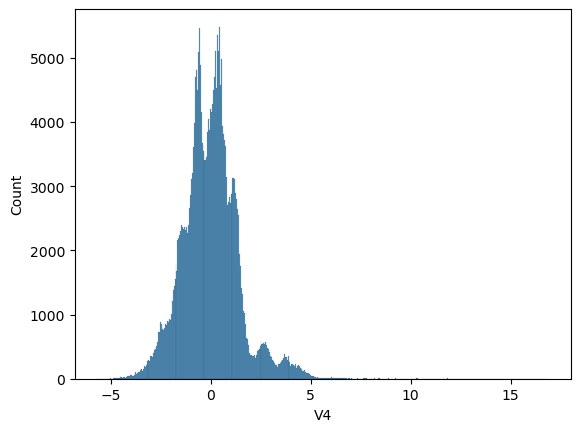

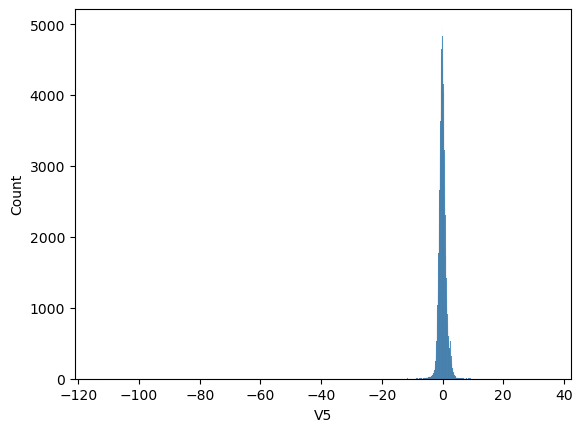

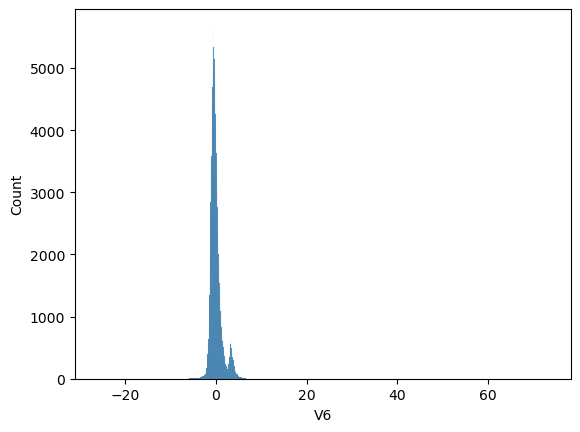

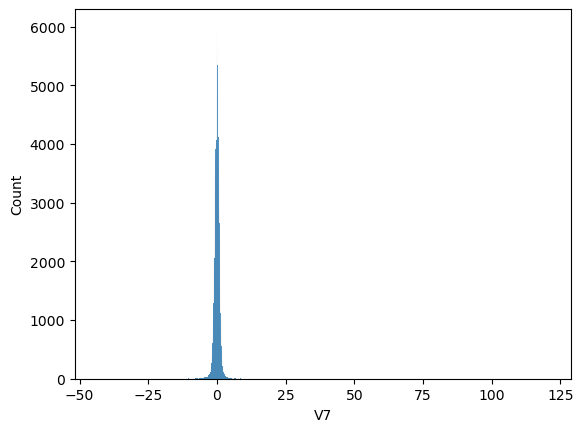

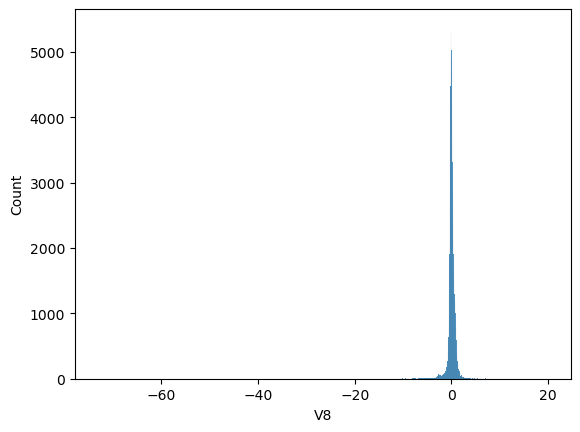

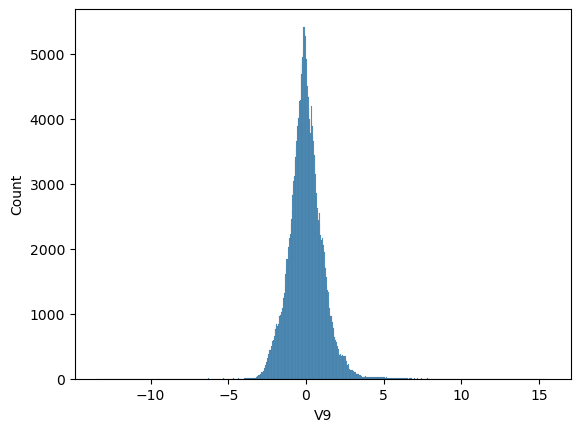

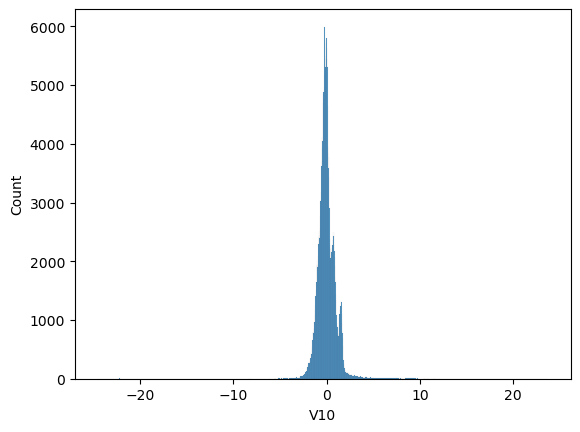

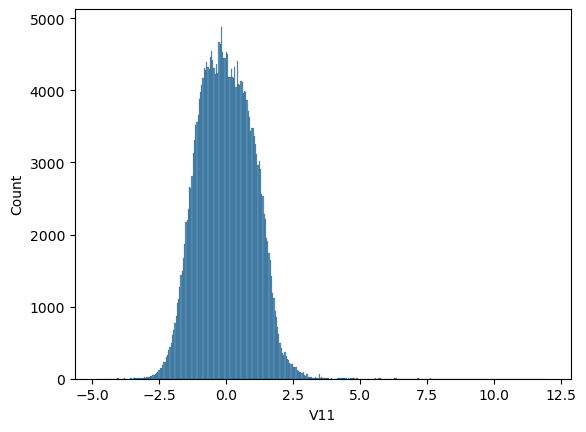

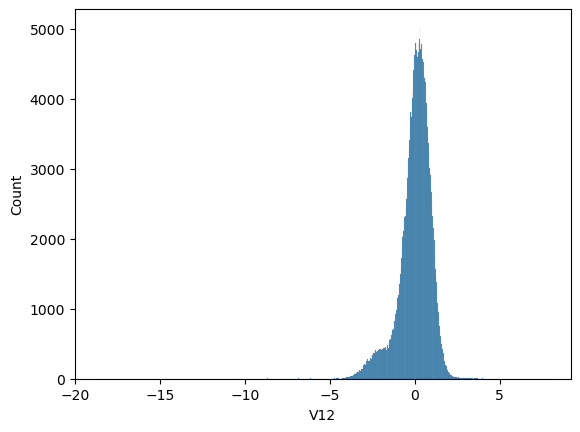

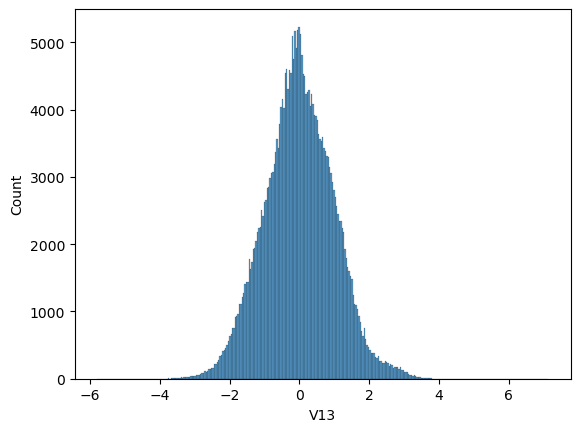

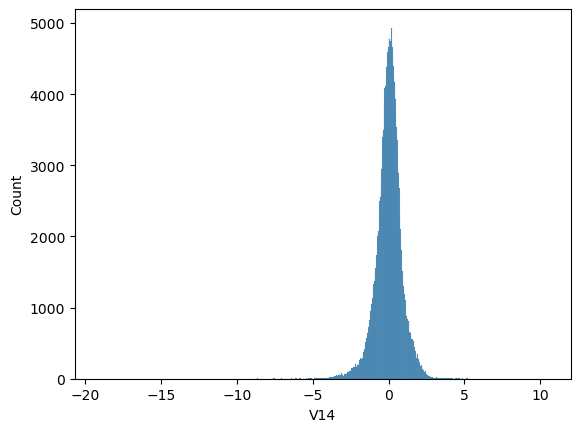

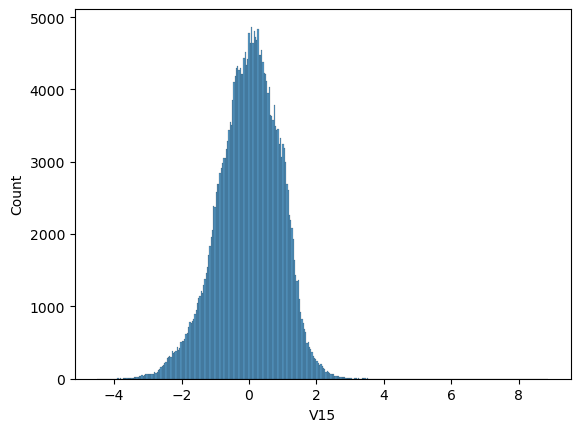

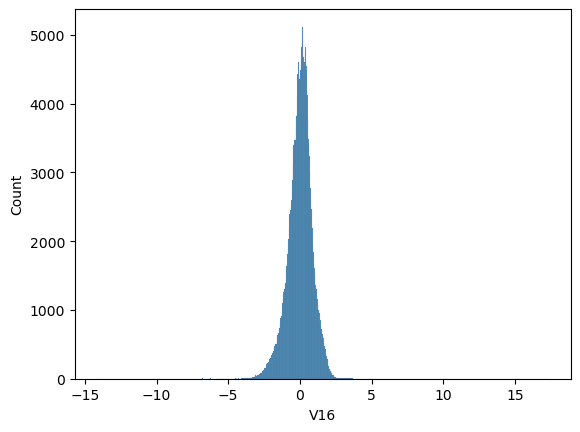

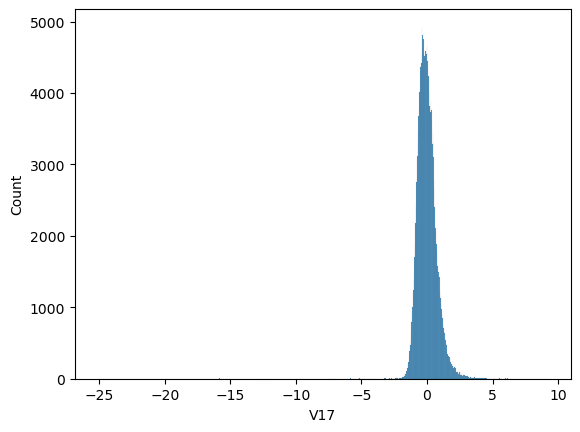

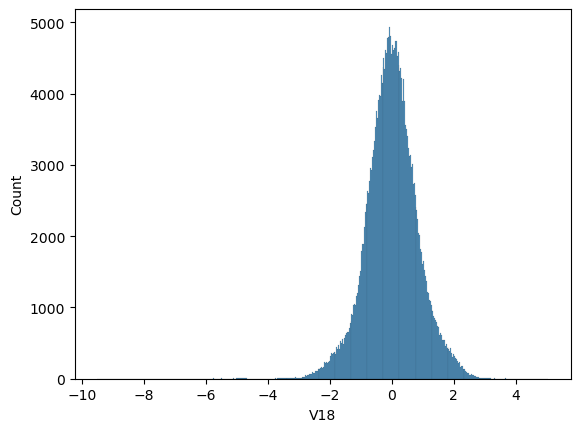

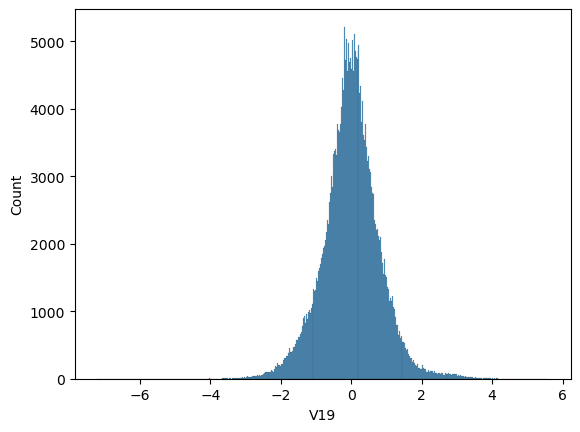

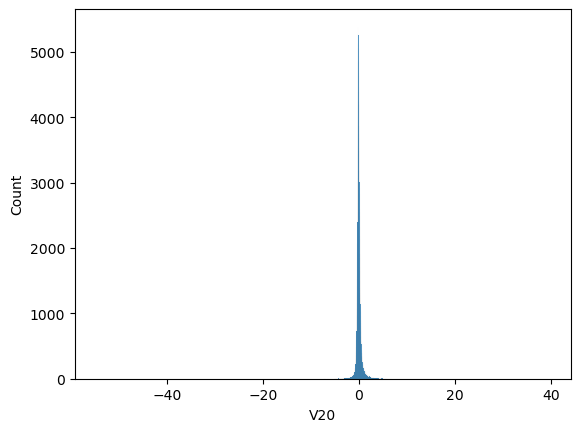

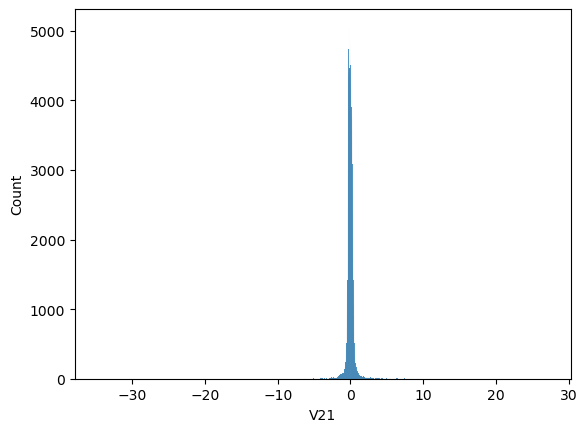

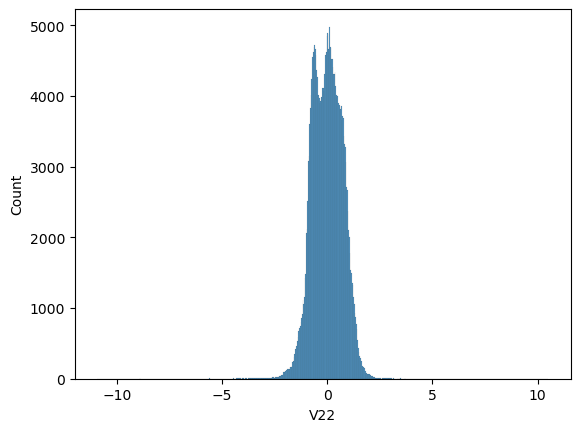

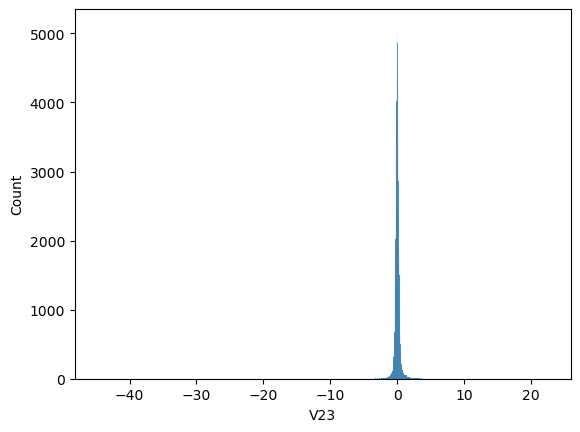

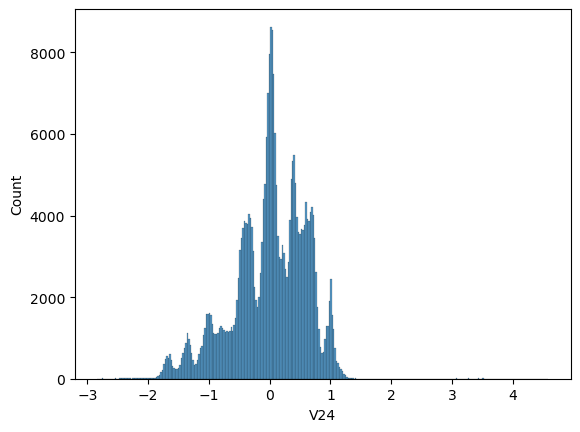

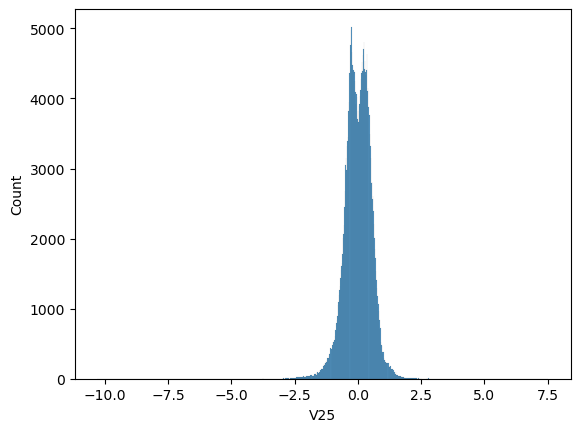

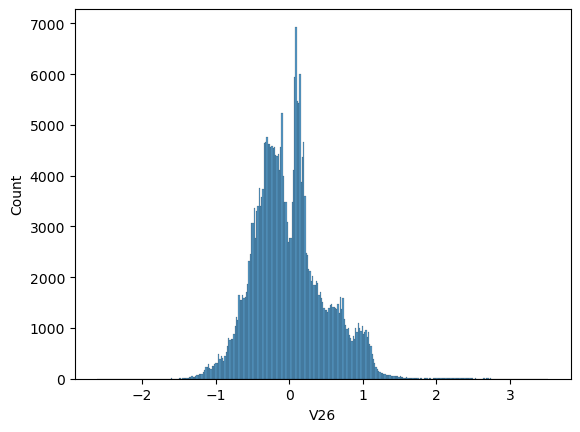

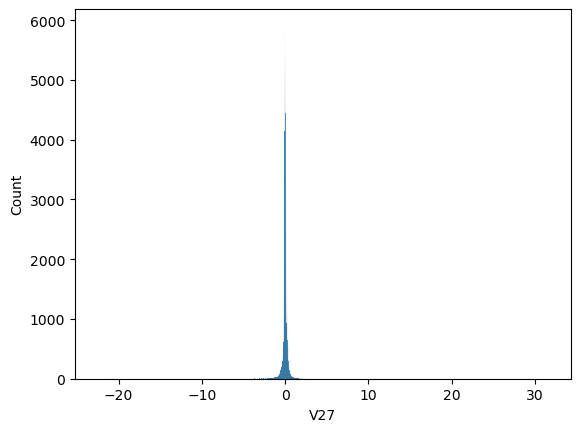

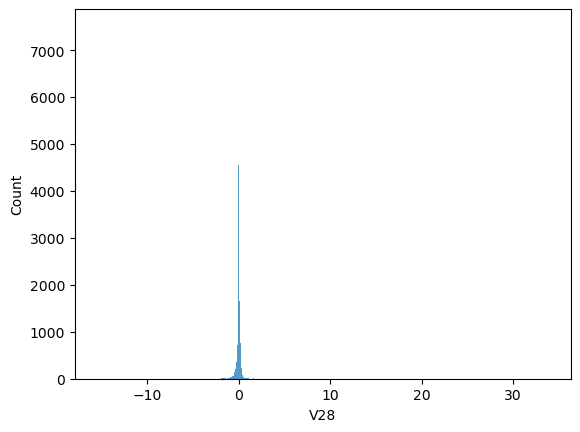

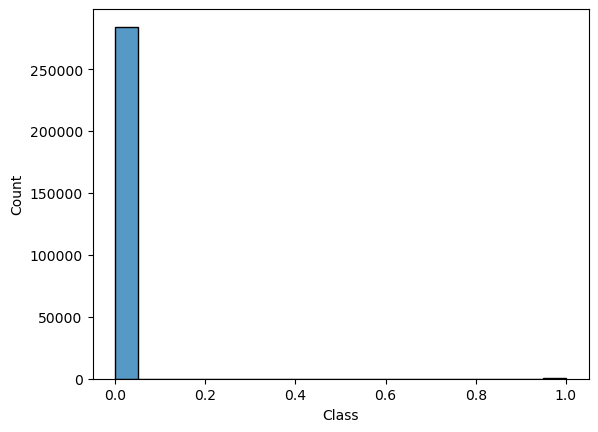

In [10]:
col = df.columns # 특성별 데이터 값의 분포. 대부분 정규분포를 띔
for e in col:
    sns.histplot(x=df[e])
    plt.show()

In [11]:
correlation_df =df.corr(method='pearson') #상관계수 Dataframe 생성

In [12]:
correlation_df.loc[abs(correlation_df['Class']) > 0.1 , ['Class']] 
#'Class' Column과 상관계수가 0.1 이상인 특성을 선택

,Class
V1,-0.101347
V3,-0.192961
V4,0.133447
V7,-0.187257
V10,-0.216883
V11,0.154876
V12,-0.260593
V14,-0.302544
V16,-0.196539
V17,-0.326481


In [ ]:
plt.figure(figsize=(50,50))
sns.set(font_scale=2.0) 
sns.heatmap(correlation_df.astype(float).corr(),annot = True)
plt.show()

In [ ]:
df = df[['V1','V3','V4','V7','V10','V11','V12','V14','V16','V17','V18','Class']]

In [15]:
df

,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,1.191857,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,-1.358354,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.966272,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,-1.158233,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,-9.834783,-2.066656,-4.918215,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,0
284803,-0.732789,2.035030,-0.738589,0.024330,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,0
284804,1.919565,-3.249640,-0.557828,-0.296827,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,0
284805,-0.240440,0.702510,0.689799,-0.686180,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,0


# Preprocessing

In [16]:
train = df.sort_values('Class')
train.reset_index(inplace=True,drop=True)

In [17]:
x = train.drop('Class',axis=1)
y = train['Class']

In [18]:
train_x = x[:][:200000]
train_y = y[:200000]
x=x[:][200000:]
y=y[:][200000:]
val_x, test_x, val_y, test_y = train_test_split(x, y, test_size=0.5, random_state=SEED,stratify=y)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(train_y.value_counts())
print(val_y.value_counts())
print(test_y.value_counts())
#train 데이터는 20만개를 사용하고, 남은 데이터를 반반으로 나누어 검증 테스트 데이터로 사용. "stratify"를 적용하여 검증데이터와 테스트 데이터의
#라벨 분포가 같게 해줌

(200000, 11)
(42403, 11)
(42404, 11)
Class
0    200000
Name: count, dtype: int64
Class
0    42157
1      246
Name: count, dtype: int64
Class
0    42158
1      246
Name: count, dtype: int64


train : val : test = 8 : 1 : 1로 데이터 분리. 

In [19]:
val_normal,val_anomaly  = val_y.value_counts()
val_anomaly_ratio = val_anomaly / (val_normal+val_anomaly)

In [20]:
val_anomaly_ratio #전체데이터 중 anomaly ratio

0.0058014763106383985

In [21]:
print(train_y.value_counts())
print(val_y.value_counts())

Class
0    200000
Name: count, dtype: int64
Class
0    42157
1      246
Name: count, dtype: int64


In [22]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
#특성들의 scale을 맞추어 주기 위해 정규화 진행

In [23]:
train_x

array([[0.93519234, 0.96784573, 0.31302266, ..., 0.35161952, 0.65674085,
        0.5181198 ],
       [0.85960113, 0.86823701, 0.46855311, ..., 0.38326605, 0.67086172,
        0.59680357],
       [0.99459788, 0.87314496, 0.23950902, ..., 0.36003005, 0.62278123,
        0.53736509],
       ...,
       [0.94465112, 0.94627813, 0.2587206 , ..., 0.36050419, 0.63656797,
        0.50060244],
       [0.9512902 , 0.94968414, 0.25013971, ..., 0.37466561, 0.63213439,
        0.47242836],
       [0.97187655, 0.90801508, 0.15116814, ..., 0.30510368, 0.63651981,
        0.69072673]])

In [24]:
print(train_x.shape)
print(val_x.shape)

(200000, 11)
(42403, 11)


In [25]:
class MyDataset(Dataset):
    def __init__(self, origin_x, origin_y):
        self.origin_x = origin_x
        self.origin_y = origin_y
        self.labels = np.array(self.origin_y)
        self.data = np.array(self.origin_x)
    def __getitem__(self, index):
        self.x = self.data[index]
        self.y = self.labels[index]
        return torch.Tensor(self.x), self.y

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [26]:
train_dataset = MyDataset(train_x,train_y)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataset = MyDataset(val_x,val_y)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
#train_loader, val_loader 선언

In [52]:

kk = iter(train_loader)
print(next(kk))

[tensor([[0.9956, 0.8883, 0.2286, 0.2077, 0.5198, 0.2358, 0.6515, 0.5764, 0.3088,
         0.6457, 0.5773],
        [0.9922, 0.8861, 0.2416, 0.2093, 0.5196, 0.2333, 0.6296, 0.5894, 0.2948,
         0.6606, 0.5723],
        [0.9928, 0.8890, 0.2798, 0.2121, 0.4939, 0.2682, 0.6783, 0.5836, 0.3453,
         0.6472, 0.4283],
        [0.9912, 0.8810, 0.4208, 0.2111, 0.5053, 0.3603, 0.6636, 0.4628, 0.4467,
         0.6764, 0.6250],
        [0.9768, 0.9448, 0.2256, 0.1998, 0.5142, 0.4205, 0.6489, 0.5563, 0.4375,
         0.6418, 0.5058],
        [0.9606, 0.9412, 0.2314, 0.2091, 0.4679, 0.2707, 0.6697, 0.5494, 0.3765,
         0.6315, 0.5083],
        [0.9936, 0.8895, 0.2796, 0.2120, 0.4946, 0.2639, 0.6747, 0.5842, 0.3475,
         0.6454, 0.4377],
        [0.9548, 0.9388, 0.2975, 0.2147, 0.4705, 0.3662, 0.5420, 0.6510, 0.3359,
         0.6851, 0.4918],
        [0.9925, 0.8973, 0.2508, 0.2042, 0.4729, 0.3619, 0.6706, 0.5266, 0.4073,
         0.6486, 0.6219],
        [0.9790, 0.9288, 0.3577, 0.2

In [28]:
input_size = train_x.shape[1]

In [29]:
torch.__version__

'1.11.0'

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(input_size,64),
            nn.LeakyReLU(),
            nn.Linear(64,8),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(8,64),
            nn.LeakyReLU(),
            nn.Linear(64,input_size),
        )


  
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x
#Autoencoder Model

In [31]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [32]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device, threshold):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        self.threshold = threshold
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 0
        #가장 높은 f1-score 기록
        best_loss = 1000000000
        #가장 적은 loss값 기록
        final_threshold = 0
        #최종 임계값 저장 변수
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x, y in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x = self.model(x)
                loss = self.criterion(x, _x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                #train
                
            mean_train_loss = np.mean(train_loss)
            
            score, true, pred, val_loss, best_threshold = self.validation(self.model, self.threshold)
            #validation 수행
            
            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}]\nVal Score : [{score}])\nVal Loss : [{val_loss}]')
            print(confusion_matrix(true, pred))
            print(f'Best threshold : [{best_threshold}]')
            
            self.scheduler.step(score)
            #Scheduler 사용
            
            '''if best_loss > val_loss:
                best_loss = val_loss
                torch.save(model.module.state_dict(), '/Users/cain/Desktop/Study/ML,DL_Project/Fraud_Detection/model/best_model.pth', _use_new_zipfile_serialization=False)
                print("Save Model~_~")'''
    
            if best_score < score:
                best_score = score
                final_threshold = best_threshold
                torch.save(model.module.state_dict(), '/Users/cain/Desktop/Study/ML,DL_Project/Fraud_Detection/model/best_model.pth', _use_new_zipfile_serialization=False)
                print("Save Model~_~")
            #Best model 저장 (기준 : f1_score)
                
        print(f'Final Best Score : [{best_score}] ')
        print(f'Final Best thresh : [{final_threshold}] ')
        return final_threshold
    def validation(self, eval_model, threshold):
        eval_model.eval()
        pred = []
        true = []
        mse = []
        val_loss = []
        best_score = 0
        best_threshold = 0
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)
                _x = eval_model(x)
                error = x-_x
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                power = torch.pow(error,2)
                tmp_mse = power.mean(axis=1).cpu()
                mse += tmp_mse
                true += y.tolist()
                
        mse_arr = np.array(mse)
        for i in threshold:
            pred = np.where(mse_arr>i, 1,0).tolist()
            f1 = f1_score(true, pred, average='macro')
            if f1 > best_score:
                best_threshold = i
                best_score = f1
        
        best_pred = np.where(mse_arr>best_threshold, 1,0).tolist()
        #validation prediction
        
        
        #plt.plot(mse)
        #plt.axhline(threshold, color='r', linewidth=1)
        #plt.show()
        return f1_score(true, best_pred, average='macro'), true, best_pred, np.mean(val_loss),best_threshold
    
    

In [33]:
threshold = []
for i in range(300):
    threshold.append(1e-4*(i+1))

In [34]:
gc.collect()
seed_everything(SEED) # Seed 고정 (모델 생성전에 다시 고정하였더니 재현이 똑같이됨..)

model = nn.DataParallel(AutoEncoder())
model.apply(weights_init)
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)#Opimizer : Adam
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold_mode='abs', min_lr=1e-8, verbose=True)
#Scheduler : ReduceLROnPlateau
trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device, threshold)
#trainer 객체 생성
final_threshold = trainer.fit()
#train start

Epoch : [1] Train loss : [0.0040097348072193565]
Val Score : [0.8050261977510629])
Val Loss : [0.0006813870570379194]
[[41973   184]
 [   56   190]]
Best threshold : [0.007200000000000001]
Save Model~_~
Epoch : [2] Train loss : [0.0005245363615825773]
Val Score : [0.8956394284112295])
Val Loss : [0.0008478306817847092]
[[42115    42]
 [   57   189]]
Best threshold : [0.0086]
Save Model~_~
Epoch : [3] Train loss : [0.0002675121698481962]
Val Score : [0.9224925610656917])
Val Loss : [0.00039166666193848383]
[[42141    16]
 [   54   192]]
Best threshold : [0.0054]
Save Model~_~
Epoch : [4] Train loss : [0.000122020294459071]
Val Score : [0.9253611001873503])
Val Loss : [0.0015140021588190826]
[[42140    17]
 [   51   195]]
Best threshold : [0.0039000000000000003]
Save Model~_~
Epoch : [5] Train loss : [9.022821988037322e-05]
Val Score : [0.9253234896707387])
Val Loss : [0.0025439894233390556]
[[42144    13]
 [   54   192]]
Best threshold : [0.0046]
Epoch : [6] Train loss : [8.158431574935

Epoch : [45] Train loss : [3.52527423328138e-05]
Val Score : [0.8503008175821395])
Val Loss : [0.00932079118090942]
[[42076    81]
 [   69   177]]
Best threshold : [0.001]
Epoch : [46] Train loss : [3.522985742791207e-05]
Val Score : [0.8530048844684994])
Val Loss : [0.009315008929519437]
[[42078    79]
 [   68   178]]
Best threshold : [0.001]
Epoch 00046: reducing learning rate of group 0 to 7.8125e-06.
Epoch : [47] Train loss : [3.5131010935729135e-05]
Val Score : [0.8529352407616082])
Val Loss : [0.009350985024354169]
[[42087    70]
 [   73   173]]
Best threshold : [0.0011]
Epoch : [48] Train loss : [3.5121060085511997e-05]
Val Score : [0.8524215787628822])
Val Loss : [0.009373132801056477]
[[42079    78]
 [   69   177]]
Best threshold : [0.001]
Epoch : [49] Train loss : [3.510617833424476e-05]
Val Score : [0.854259970509386])
Val Loss : [0.009396523590344855]
[[42087    70]
 [   72   174]]
Best threshold : [0.0011]
Epoch : [50] Train loss : [3.5087939621371335e-05]
Val Score : [0.8

Epoch : [89] Train loss : [3.4904853110783734e-05]
Val Score : [0.8529352407616082])
Val Loss : [0.009539386571268578]
[[42087    70]
 [   73   173]]
Best threshold : [0.0011]
Epoch : [90] Train loss : [3.490473835845478e-05]
Val Score : [0.8529352407616082])
Val Loss : [0.00953912789426703]
[[42087    70]
 [   73   173]]
Best threshold : [0.0011]
Epoch : [91] Train loss : [3.490459335014748e-05]
Val Score : [0.8529352407616082])
Val Loss : [0.00954011060251655]
[[42087    70]
 [   73   173]]
Best threshold : [0.0011]
Epoch : [92] Train loss : [3.490463496673328e-05]
Val Score : [0.8529352407616082])
Val Loss : [0.009539627878164161]
[[42087    70]
 [   73   173]]
Best threshold : [0.0011]
Epoch : [93] Train loss : [3.4904451954571414e-05]
Val Score : [0.8529352407616082])
Val Loss : [0.009540240117671238]
[[42087    70]
 [   73   173]]
Best threshold : [0.0011]
Epoch : [94] Train loss : [3.490460838671425e-05]
Val Score : [0.8529352407616082])
Val Loss : [0.009540470470119475]
[[42087

In [35]:
test_x_minmax = scaler.transform(test_x)
test_dataset = MyDataset(test_x_minmax,test_y)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)
#test data minmaxscaler 적용 후 Dataloader 생성

In [36]:
test_x

,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18
204006,-1.044363,1.908652,1.371441,-0.040865,-0.181907,0.398370,0.628723,0.278636,-0.765611,0.336126,-0.714577
229235,-2.329285,-1.857204,-2.387838,-1.533077,-0.565004,-0.758175,0.481487,1.115374,1.399911,-0.543525,0.177243
214333,0.982807,0.287023,1.156696,-0.019093,0.186287,1.293693,0.302388,0.812136,0.122244,-0.374649,0.143478
204306,-0.466638,1.685863,-0.106430,0.640973,-0.158985,1.579857,1.011713,0.236663,0.308072,-0.602340,0.005328
238114,-0.365921,1.130107,-0.074356,0.645872,-0.567742,-0.220877,0.172795,-0.528232,0.169073,0.126117,-0.536119
...,...,...,...,...,...,...,...,...,...,...,...
279029,-1.706781,1.963925,1.145748,-1.132155,-0.394503,0.622091,-0.133147,0.750219,0.757750,-0.465280,1.440839
223563,1.077031,0.475618,1.345831,-0.070740,0.062973,1.191239,0.809438,0.456335,-0.541867,0.138314,-0.435980
204216,1.309111,0.855223,-0.908706,-1.365295,0.782006,0.052929,0.095761,-0.255924,-0.073387,-1.027205,2.514518
282687,1.161638,0.598815,0.499380,-0.093862,0.049716,1.941058,1.380397,0.412694,0.132154,-0.339487,-0.601835


In [37]:
def testing(model, threshold, test_loader, device):
    model.to(device)
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        for x, y in iter(test_loader):
            x = x.float().to(device)
            _x = model(x)
            error = x-_x
            power = torch.pow(error,2)
            tmp_mse = power.mean(axis=1).cpu()
            batch_pred = np.where(np.array(tmp_mse)>threshold, 1,0).tolist()
            pred += batch_pred
            true += y.tolist()
    print(f1_score(true, pred, average='macro'))
    print(confusion_matrix(true, pred))

In [38]:
load_model = AutoEncoder()
load_model.load_state_dict(torch.load('/Users/cain/Desktop/Study/ML,DL_Project/Fraud_Detection/model/best_model.pth'))
load_model = nn.DataParallel(load_model)
load_model.eval()
testing(load_model,final_threshold, test_loader, device)
#test 진행


0.933272682944638
[[42148    10]
 [   50   196]]
